## Praktikum 1 | RNN untuk Analisis Sentimen

### Setup
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Setup input pipeline

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.
Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'The movie had a cute opening, I truly believed I was in for one of the best romantic comedies i\'ve seen in a while... there was something particular "foreign" about the way the movie was set up, realistic yet somewhat abstract and mystical. But then the story line started becoming more and more unrealistic. To say that the ending was CORNY and PREDICTABLE would almost be an understatement... The most typical romantic ending where everything goes great for every \'likable\' character. A scene where the main character realises that he has made a mistake and chases the "woman of his dreams" only to confess his love for her in front of a sympathetic crowd of on- lookers. Come on. In the end, the \'good guys\' win, \'bad guys\' loose... You get the picture. A WASTE of a potentially interesting movie.'
 b"This is a bit of a first for me, the first time I have ever been disappointed in a Tim Burton film. POTA isn't a bad film (great sets, costumes and the odd great performance) bu

### Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 2, 18, 67, ...,  0,  0,  0],
       [11,  7,  4, ...,  0,  0,  0],
       [ 1,  1,  7, ...,  0,  0,  0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The movie had a cute opening, I truly believed I was in for one of the best romantic comedies i\'ve seen in a while... there was something particular "foreign" about the way the movie was set up, realistic yet somewhat abstract and mystical. But then the story line started becoming more and more unrealistic. To say that the ending was CORNY and PREDICTABLE would almost be an understatement... The most typical romantic ending where everything goes great for every \'likable\' character. A scene where the main character realises that he has made a mistake and chases the "woman of his dreams" only to confess his love for her in front of a sympathetic crowd of on- lookers. Come on. In the end, the \'good guys\' win, \'bad guys\' loose... You get the picture. A WASTE of a potentially interesting movie.'
Round-trip:  the movie had a [UNK] opening i truly [UNK] i was in for one of the best romantic [UNK] ive seen in a while there was something particular [UNK] about the way the mo

### Buat Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[-0.00814811]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 62ms/step
[-0.00814811]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train Model

In [15]:
history = model.fit(train_dataset, epochs=10,
  validation_data=test_dataset,
  validation_steps=30)

Epoch 1/10
391/391 [==============================] - 53s 111ms/step - loss: 0.6441 - accuracy: 0.5612 - val_loss: 0.4823 - val_accuracy: 0.7589
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4293 - accuracy: 0.8056 - val_loss: 0.3821 - val_accuracy: 0.8391
Epoch 3/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3612 - accuracy: 0.8435 - val_loss: 0.3558 - val_accuracy: 0.8479
Epoch 4/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3305 - accuracy: 0.8583 - val_loss: 0.3381 - val_accuracy: 0.8500
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3141 - accuracy: 0.8666 - val_loss: 0.3284 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 27s 67ms/step - loss: 0.3100 - accuracy: 0.8688 - val_loss: 0.3292 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3026 - accuracy: 0.8705 - val_loss: 0.3267 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3175 - accuracy: 0.8578
Test Loss: 0.31746312975883484
Test Accuracy: 0.8578000068664551


(0.0, 0.6615501135587692)

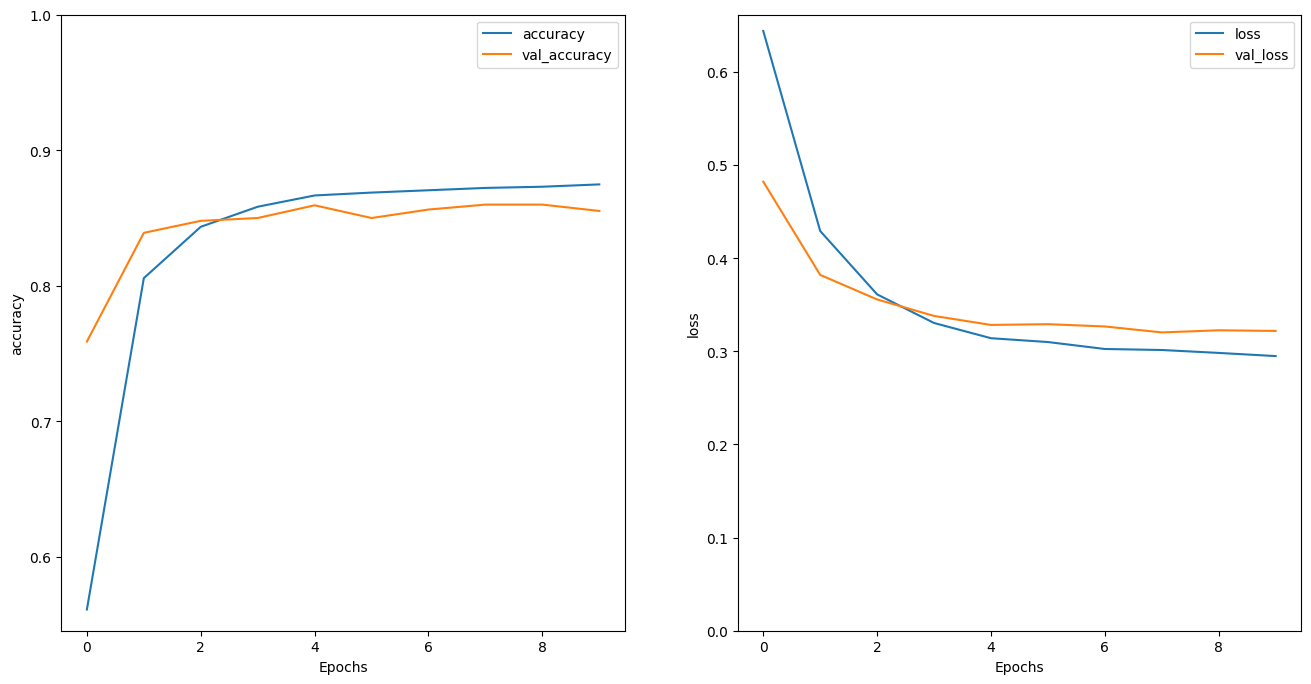

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


### Stack two or more LSTM layers

In [19]:
model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  optimizer=tf.keras.optimizers.Adam(1e-4),
  metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
  validation_data=test_dataset,
  validation_steps=30)

Epoch 1/10
391/391 [==============================] - 82s 155ms/step - loss: 0.6438 - accuracy: 0.5642 - val_loss: 0.5070 - val_accuracy: 0.6979
Epoch 2/10
391/391 [==============================] - 47s 121ms/step - loss: 0.4189 - accuracy: 0.8124 - val_loss: 0.3823 - val_accuracy: 0.8365
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3543 - accuracy: 0.8507 - val_loss: 0.3436 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3293 - accuracy: 0.8624 - val_loss: 0.3304 - val_accuracy: 0.8490
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3147 - accuracy: 0.8677 - val_loss: 0.3299 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3105 - accuracy: 0.8691 - val_loss: 0.3195 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3046 - accuracy: 0.8704 - val_loss: 0.3231 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3207 - accuracy: 0.8497
Test Loss: 0.3207293152809143
Test Accuracy: 0.8497200012207031


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.673867]]


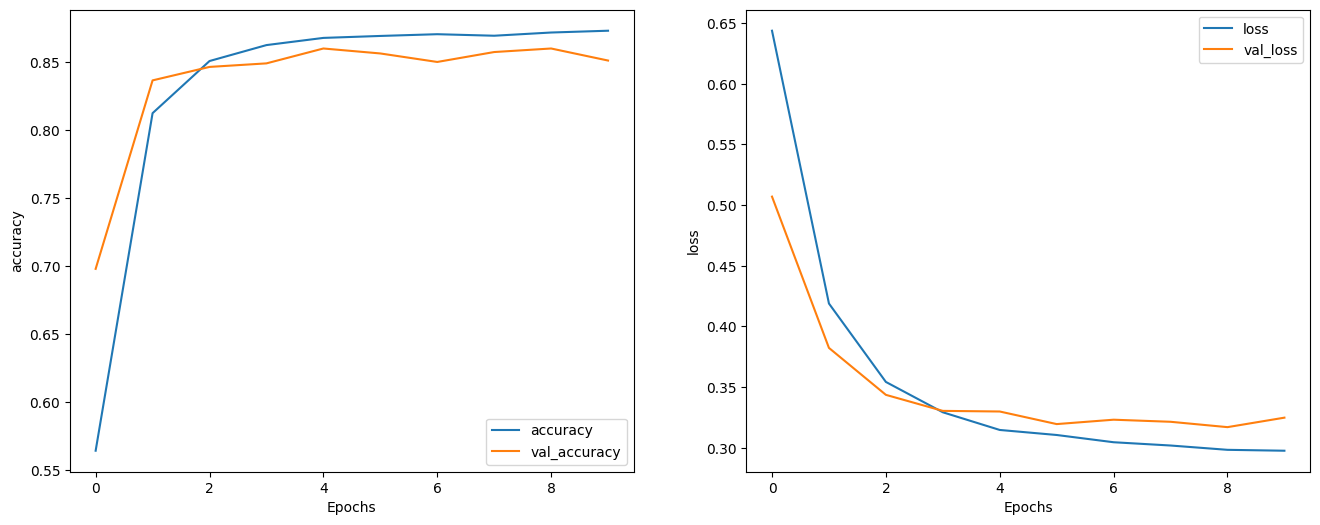

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')